In [ ]:
import contextlib
import faulthandler
import io
import multiprocessing
import os
import platform
import signal
import random
import subprocess
import tempfile
import gzip
import json
from typing import *
import traceback

java_exec = ""
node_exec = ""
tsc_exec = ""
go_exec = ""
php_exec = ""
cs_exec = ""

def check_correctness(
        task_id: str,
        sample: dict,
        language_type: str,
        timeout: float = 3.0,
        tmp_dir: str = None,
        completion_id: Optional[int] = None,
) -> Dict:
    """
    Evaluates the functional correctness of a completion by running the test
    suite provided in the problem.
    """

    def unsafe_execute(tmp_dir):
        random_id = random.randint(1, 100000)
        if "python" in language_type.lower():
            with create_tempdir():
                # These system calls are needed when cleaning up tempdir.
                import os
                import shutil
                rmtree = shutil.rmtree
                rmdir = os.rmdir
                chdir = os.chdir
                # Disable functionalities that can make destructive changes to the test.
                # reliability_guard()
                try:
                    exec_globals = {}
                    with swallow_io():
                        with time_limit(timeout):
                            # WARNING
                            # This program exists to execute untrusted model-generated code. Although
                            # it is highly unlikely that model-generated code will do something overtly
                            # malicious in response to this test suite, model-generated code may act
                            # destructively due to a lack of model capability or alignment.
                            # Users are strongly encouraged to sandbox this evaluation suite so that it
                            # does not perform destructive actions on their host or network.
                            # Once you have read this disclaimer and taken appropriate precautions,
                            # uncomment the following line and proceed at your own risk:
                            exec(sample["test_code"], exec_globals)
                        result.append("passed")
                except TimeoutException:
                    result.append("timed out")
                except AssertionError as e:
                    result.append(f"failed: AssertionError")
                except BaseException as e:
                    result.append(f"failed: {e}")
                #print(sample["test_code"])
                #print(result)
                # Needed for cleaning up.
                shutil.rmtree = rmtree
                os.rmdir = rmdir
                os.chdir = chdir
        
        
    manager = multiprocessing.Manager()
    result = manager.list()

    p = multiprocessing.Process(target=unsafe_execute, args=(tmp_dir,))
    p.start()
    p.join(timeout=timeout + 1)
    if p.is_alive():
        p.kill()

    if not result:
        result.append("timed out")

    return {
        "task_id"      : task_id,
        "completion_id": completion_id,
        "result"       : result[0],
        "passed"       : result[0] == "passed",
        "finish"       : -1 if "finish" not in sample else sample["finish"],
        "code"         : sample["test_code"]
    }

# Copyright (c) OpenAI (https://openai.com)

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.
# ============================================================================
@contextlib.contextmanager
def time_limit(seconds: float):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")

    signal.setitimer(signal.ITIMER_REAL, seconds)
    signal.signal(signal.SIGALRM, signal_handler)
    try:
        yield
    finally:
        signal.setitimer(signal.ITIMER_REAL, 0)


@contextlib.contextmanager
def swallow_io():
    stream = WriteOnlyStringIO()
    with contextlib.redirect_stdout(stream):
        with contextlib.redirect_stderr(stream):
            with redirect_stdin(stream):
                yield


@contextlib.contextmanager
def create_tempdir():
    with tempfile.TemporaryDirectory() as dirname:
        with chdir(dirname):
            yield dirname


class TimeoutException(Exception):
    pass


class WriteOnlyStringIO(io.StringIO):
    """ StringIO that throws an exception when it's read from """

    def read(self, *args, **kwargs):
        raise IOError

    def readline(self, *args, **kwargs):
        raise IOError

    def readlines(self, *args, **kwargs):
        raise IOError

    def readable(self, *args, **kwargs):
        """ Returns True if the IO object can be read. """
        return False


class redirect_stdin(contextlib._RedirectStream):  # type: ignore
    _stream = 'stdin'


@contextlib.contextmanager
def chdir(root):
    if root == ".":
        yield
        return
    cwd = os.getcwd()
    os.chdir(root)
    try:
        yield
    except BaseException as exc:
        raise exc
    finally:
        os.chdir(cwd)


def reliability_guard(maximum_memory_bytes: Optional[int] = None):
    """
    This disables various destructive functions and prevents the generated code
    from interfering with the test (e.g. fork bomb, killing other processes,
    removing filesystem files, etc.)

    WARNING
    This function is NOT a security sandbox. Untrusted code, including, model-
    generated code, should not be blindly executed outside of one. See the 
    Codex paper for more information about OpenAI's code sandbox, and proceed
    with caution.
    """

    if maximum_memory_bytes is not None:
        import resource
        resource.setrlimit(resource.RLIMIT_AS, (maximum_memory_bytes, maximum_memory_bytes))
        resource.setrlimit(resource.RLIMIT_DATA, (maximum_memory_bytes, maximum_memory_bytes))
        if not platform.uname().system == 'Darwin':
            resource.setrlimit(resource.RLIMIT_STACK, (maximum_memory_bytes, maximum_memory_bytes))

    faulthandler.disable()

    import builtins
    builtins.exit = None
    builtins.quit = None

    import os
    os.environ['OMP_NUM_THREADS'] = '1'

    os.kill = None
    os.system = None
    os.putenv = None
    os.remove = None
    os.removedirs = None
    os.rmdir = None
    os.fchdir = None
    os.setuid = None
    os.fork = None
    os.forkpty = None
    os.killpg = None
    os.rename = None
    os.renames = None
    os.truncate = None
    os.replace = None
    os.unlink = None
    os.fchmod = None
    os.fchown = None
    os.chmod = None
    os.chown = None
    os.chroot = None
    os.fchdir = None
    os.lchflags = None
    os.lchmod = None
    os.lchown = None
    os.getcwd = None
    os.chdir = None

    import shutil
    shutil.rmtree = None
    shutil.move = None
    shutil.chown = None

    import subprocess
    subprocess.Popen = None  # type: ignore

    __builtins__['help'] = None

    import sys
    sys.modules['ipdb'] = None
    sys.modules['joblib'] = None
    sys.modules['resource'] = None
    sys.modules['psutil'] = None
    sys.modules['tkinter'] = None

In [102]:
import re

def build_deepseekcoder_instruction(languge: str, question: str):
    return '''
Please continue to complete the function. You are not allowed to modify the given code and do the completion only. Please return all completed function in a codeblock. Here is the given code to do completion:
```{}
{}
```
'''.strip().format(languge.lower(), question.strip())

languge_settings = {
    'python': {
        'full_name': 'Python',
        'indent': 4,
    },
    'cpp': {
        'full_name': 'cpp',
        'indent': 0,
        'main': "int main()",
    },
    'java': {
        'full_name': 'Java',
        'indent': 4,
        'main': "public static void main",
    },
    'cs': {
        'full_name': "csharp",
        'indent': 0,
        'main': "public static void Main",
    },
    'php': {
        'full_name': "PHP",
        'indent': 0,
    },
    'ts': {
        'full_name': "TypeScript",
        'indent': 0,
    },
    'js': {
        'full_name': "JavaScript",
        'indent': 0
    },
    'sh': {
        'full_name': "Bash",
        'indent': 0
    }
}

def get_function_name(question: str, lang: str):
    func_lines = [x for x in question.strip().split('\n') if x.strip()]

    if lang.lower() == 'python':
        func_idx = [i for i in range(len(func_lines)) if func_lines[i].startswith("def ")][-1]
        func_name = func_lines[func_idx].split('(')[0].strip()
        func_prefix = "\n".join(func_lines[:func_idx])
        return func_name, func_prefix
    
    func_name = func_lines[-1].split('{')[0].strip()
    func_prefix = "\n".join(func_lines[:-1])
    return func_name, func_prefix

def extract_generation_code(example: str, lang_code: str, verbose: bool=False):
    task_id = example['task_id']
    output = example.get('output', example.get("gpt_completion"))
    question = example["prompt"].strip()
    setting = languge_settings[lang_code]
    lang = setting['full_name']
    indent = setting['indent']

    try:
        code_block: str = re.findall(f'```{lang.lower()}\n(.*?)```', output, re.DOTALL | re.IGNORECASE)[0]
        if verbose:
            print(">>> Task: {}\n{}".format(task_id, code_block))
        
        # Remove main
        if setting.get('main', None) and setting['main'] in code_block:
            main_start = code_block.index(setting['main'])
            code_block = code_block[:main_start]
        
        func_name, func_prefix = get_function_name(question, lang)

        try:
            start = code_block.lower().index(func_name.lower())
            indent = 0
            while start - indent >= 0 and code_block[start - indent-1] == ' ':
                indent += 1
            
            try:
                end = code_block.rindex('\n' + ' '*indent + '}')
            except:
                end = len(code_block)
        except:
            start = 0
            try:
                end = code_block.rindex('\n' + ' '*indent + '}')
            except:
                end = len(code_block)

        body = code_block[start:end]

        if lang_code.lower() in ['php', 'ts', 'js']:
            body += '\n' + ' '*indent + '}'
    
        generation = func_prefix + '\n' + body + '\n'
        example['generation'] = generation

    except Exception as ex:
        print("Failed to extract code block with error `{}`:\n>>> Task: {}\n>>> Output:\n{}".format(
            ex, task_id, output
        ))
        example['generation'] = example['prompt'] + '\n' + output
    
    return example

def cleanup_code(
    code: str,
    language_type: str = None,
    dataset: str = None,
    issft: bool = False,
    stop_words = []
):
    """
    Cleans up the generated code.
    """

    if language_type.lower() == "python":
        if issft:
            code = _clean_python_code_for_sft(code)
        stop_words = ["\ndef", "\nclass", "\nif", "\n#", "\nprint"]
        code = _truncate_code_at_stopwords(code, stop_words)
    elif language_type.lower() == "ts":
        code = _truncate_code_at_stopwords(code, stop_words + ["\nexport", "\nimport", "\nexport default", "\nimport default", "\nconsole.log"])
    else:
        code = _truncate_code_at_stopwords(code, stop_words)

    return code

def _clean_python_code_for_sft(code):
    code = code.replace("\r", "")
    if "```python" in code:
        code_start_idx = code.index("```python")
        code = code[code_start_idx:].replace("```python", "").strip()
        end_idx = code.find("```") if "```" in code else len(code)
        code = code[:end_idx].strip()

    return code

def _truncate_code_at_stopwords(code, stop_words):
    min_stop_idx = len(code)
    for stop_word in stop_words:
        stop_index = code.find(stop_word)
        if 0 <= stop_index < min_stop_idx:
            min_stop_idx = stop_index
    return code[:min_stop_idx]

In [103]:
import boto3
import json
from datasets import Dataset, load_dataset
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sal.utils.math import (
    find_majority_answer, extract_completion_answers,
    memoized_canonical_form, find_answer_with_largest_sum,
    strip_string
)

def download_and_load_json(full_path, local_path):
    file_dir = full_path
    bucket_name, key = file_dir.replace('s3://', '').split('/', 1)
    s3 = boto3.client('s3')
    # Remove local_path if it exists
    try:
        os.remove(local_path)
    except OSError:
        pass
    try:
        s3.download_file(bucket_name, key, local_path)
    except Exception as e:
        print(f"Error downloading file: {e}")
        print(key)

    # print(f"File downloaded to {local_path}")
    model_responses = []
    with open(local_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        return data

def load_humaneval():
    dataset = load_dataset("openai/openai_humaneval", split="test")
    convs = [
        [
            # {"role": "user", "content": build_deepseekcoder_instruction('Python', prompt)},
            {"role": "user", "content": prompt},
        ]
        for prompt in dataset["prompt"]
    ]
    return convs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [188]:
all_answers = []
qid = 114
all_seeds = [0, 1, 2, 3, 4, 5, 6, 7]
save_name = 'human_eval'
for seed in all_seeds:
    file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/dpsk_new_sample_long_long_with_final_answer_human_eval/seed_{seed}/answers_{qid}.json'
    # file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/{folder_name}/seed_{seed}/answers_{qid}.json'
    F = download_and_load_json(file_dir, f'/tmp/answers_{save_name}.json')
    all_answers.append(F)

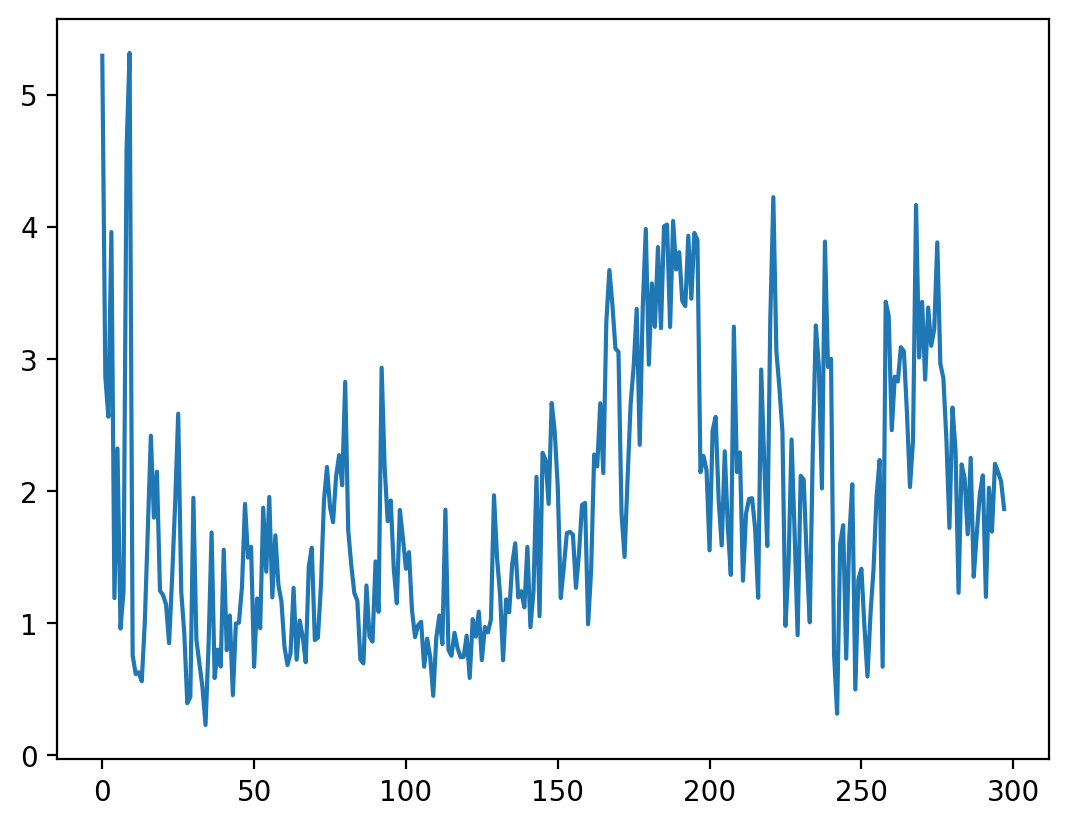

In [189]:
qid = 114
base_path = '/root/tts_and_entropy/outputs/entropy_log_math'
aime_ent = np.load(
    os.path.join(base_path, f'entropy_{qid}_new_dpsk_new_with_sample_ngram_with_final_answer_str_human_eval.npy')
)
plt.plot(aime_ent[:, 1])

In [116]:
IMPORT_HELPER = {
    "python": [
        "import math",
        "import re",
        "import sys",
        "import copy",
        "import datetime",
        "import itertools",
        "import collections",
        "import heapq",
        "import functools",
        "import hashlib",
        "import numpy",
        "import numpy as np",
        "import string",
        "from typing import *",
        "from collections import *",
    ],
    "go"    : [
        "math",
        "strings",
        "fmt",
        "strconv",
        "time",
        "bytes",
        "regexp",
        "sort",
        "math/rand",
        "crypto/md5",
    ],
    "cpp"   : [
        "#include<stdlib.h>",
        "#include<algorithm>",
        "#include<math.h>",
        "#include<stdio.h>",
        "#include<vector>",
        "#include<string>",
        "#include<climits>",
        "#include<cstring>",
        "#include<iostream>",
        "#include<cassert>"
    ],
    "cs": ["using System.Numerics;", "using System.Diagnostics;", "using System.Collections.Generic;", "using System.Linq;", "using System.Text;", "using System.Security.Cryptography;", "using System.Collections.Generic;"]
}


LANGUAGE_NAME = {
    "cpp"   : "CPP",
    "go"    : "Go",
    "java"  : "Java",
    "js"    : "JavaScript",
    "python": "Python",
}

In [190]:
print(test_string)

import math
import re
import sys
import copy
import datetime
import itertools
import collections
import heapq
import functools
import hashlib
import numpy
import numpy as np
import string
from typing import *
from collections import *
def odd_count(lst):
    """Given a list of strings, where each string consists of only digits, return a list.
    Each element i of the output should be "the number of odd elements in the
    string i of the input." where all the i's should be replaced by the number
    of odd digits in the i'th string of the input.

    >>> odd_count(['1234567'])
    ["the number of odd elements 4n the str4ng 4 of the 4nput."]
    >>> odd_count(['3',"11111111"])
    ["the number of odd elements 1n the str1ng 1 of the 1nput.",
     "the number of odd elements 8n the str8ng 8 of the 8nput."]
    """
 

To solve this problem, we need to create a function that processes a list of strings, each containing only digits, and returns a list of formatted strings. Each formatted st

In [187]:
print(output)

 

To solve this problem, we need to create a function that processes a list of strings, each containing only digits, and returns a list of formatted strings. Each formatted string should indicate the number of odd digits in the corresponding input string, replacing all occurrences of the letter 'n' in a predefined template with the count.

### Approach
1. **Problem Analysis**: The task involves counting the number of odd digits in each string of the input list. An odd digit is any digit that is not even (i.e., 1, 3, 5, 7, 9). For each string, we need to replace every occurrence of the letter 'n' in a fixed template with the count of odd digits found in that string.
2. **Key Insight**: The solution requires two main steps for each string in the input list:
   - Count the number of odd digits in the string.
   - Replace all 'n' characters in the predefined template with the count obtained in the previous step.
3. **Algorithm Selection**: The algorithm involves iterating over each string

In [186]:
dataset = load_dataset("openai/openai_humaneval", split="test")
qid = 113
task_id = 0
output = all_answers[0][100][2]
question = dataset[qid]['prompt'].strip()

sample = extract_generation_code(
    {
        'task_id': task_id,
        'prompt': question,
        'output': output,
    },
    'python',
    verbose=False
)
sample['test'] = dataset[qid]['test']

task_id = sample["task_id"]
prompt = sample["prompt"]
test = sample['test']
code = sample["generation"]

# Pre-process for different languages
test_setup = "\n".join(IMPORT_HELPER["python"]) + "\n"
test_string = test_setup + code + "\n" + test + "\n" + f"check({dataset[qid]['entry_point']})"
sample["test_code"] = test_string

check_correctness(
    task_id='123',
    sample=sample,
    language_type='python',
    timeout=10,
    tmp_dir='/tmp',
)

Failed to extract code block with error `list index out of range`:
>>> Task: 0
>>> Output:
 

To solve this problem, we need to create a function that processes a list of strings, each containing only digits, and returns a list of formatted strings. Each formatted string should indicate the number of odd digits in the corresponding input string, replacing all occurrences of the letter 'n' in a predefined template with the count.

### Approach
1. **Problem Analysis**: The task involves counting the number of odd digits in each string of the input list. An odd digit is any digit that is not even (i.e., 1, 3, 5, 7, 9). For each string, we need to replace every occurrence of the letter 'n' in a fixed template with the count of odd digits found in that string.
2. **Key Insight**: The solution requires two main steps for each string in the input list:
   - Count the number of odd digits in the string.
   - Replace all 'n' characters in the predefined template with the count obtained in the p

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'task_id': '123',
 'completion_id': None,
 'result': 'failed: invalid syntax (<string>, line 30)',
 'passed': False,
 'finish': -1,
 'code': 'import math\nimport re\nimport sys\nimport copy\nimport datetime\nimport itertools\nimport collections\nimport heapq\nimport functools\nimport hashlib\nimport numpy\nimport numpy as np\nimport string\nfrom typing import *\nfrom collections import *\ndef odd_count(lst):\n    """Given a list of strings, where each string consists of only digits, return a list.\n    Each element i of the output should be "the number of odd elements in the\n    string i of the input." where all the i\'s should be replaced by the number\n    of odd digits in the i\'th string of the input.\n\n    >>> odd_count([\'1234567\'])\n    ["the number of odd elements 4n the str4ng 4 of the 4nput."]\n    >>> odd_count([\'3\',"11111111"])\n    ["the number of odd elements 1n the str1ng 1 of the 1nput.",\n     "the number of odd elements 8n the str8ng 8 of the 8nput."]\n    """\n